# Análisis Estadístico-Ecológico: Camino 2
## Modelo Gamma GLM con variable categórica de perturbación

Este notebook implementa el **segundo camino** descrito en `procedimiento.md`:
- Modelo Gamma GLM con enlace log
- Variable respuesta: `densidad_ponderada`
- Variables explicatorias: 
  - `apertura_s` (apertura del dosel estandarizada)
  - `perturbacion` (categórica: Planillas Sur [U1-U4] vs Planillas [U5-U12])
- Validación tipo DHARMa

## 1. Importar librerías necesarias


In [1]:
# 1. Librerías básicas
import pandas as pd
import numpy as np

# 2. Graficación
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Modelos estadísticos
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 4. Pruebas estadísticas
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as st

# 5. Estandarización
from sklearn.preprocessing import StandardScaler

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y preparar los datos

Cargamos `resultados.xlsx` y creamos la variable categórica de perturbación:
- **Planillas Sur**: Unidades 1-4 (alta perturbación)
- **Planillas**: Unidades 5-12 (menor perturbación)


In [2]:
# Cargar datos desde resultados.xlsx
df = pd.read_excel("resultados.xlsx")

# Eliminar la fila de totales si existe
df = df[df["Unidad"] != "Total"].copy()

# Calcular densidad ponderada usando N_flor directamente
df["densidad_ponderada"] = df["N_flor"] / (df["Total"] / 10000)  # por m²

# La apertura es la proporción de área expuesta (Prc_expuesto)
df["apertura"] = df["Prc_expuesto"]

# Crear variable categórica de perturbación
# U1-U4: Planillas Sur (alta perturbación)
# U5-U12: Planillas (menor perturbación)
df["perturbacion"] = df["Unidad"].apply(
    lambda x: "PlanillasSur" if x <= 4 else "Planillas"
)

# Mostrar tabla con la clasificación
print("Datos cargados con variable de perturbación:")
print(df[["Unidad", "densidad_ponderada", "apertura", "perturbacion"]])
print(f"\nTotal de observaciones: {len(df)}")
print(f"\nDistribución de perturbación:")
print(df["perturbacion"].value_counts())

Datos cargados con variable de perturbación:
   Unidad  densidad_ponderada  apertura  perturbacion
0       1           40.497769  0.823955  PlanillasSur
1       2           29.823562  0.841026  PlanillasSur
2       3            6.294811  0.859549  PlanillasSur
3       4           37.958269  0.832559  PlanillasSur
4       5           37.356142  0.631171     Planillas
5       6            0.239044  0.497582     Planillas
6       7           65.515438  0.181998     Planillas
7       8          117.241695  0.749469     Planillas
8       9           29.721378  0.580353     Planillas
9      10           37.625405  0.889373     Planillas
10     11         3163.038978  0.925807     Planillas
11     12           28.466326  0.869556     Planillas

Total de observaciones: 12

Distribución de perturbación:
perturbacion
Planillas       8
PlanillasSur    4
Name: count, dtype: int64


## 3. Preparación de variables

Estandarizamos `apertura` y convertimos `perturbacion` a tipo categórico.


In [3]:
# Estandarizar apertura
scaler = StandardScaler()
df["apertura_s"] = scaler.fit_transform(df[["apertura"]])

# Convertir perturbación en variable categórica
df["perturbacion"] = df["perturbacion"].astype("category")

print("Variables preparadas:")
print(f"\nNiveles de perturbación: {list(df['perturbacion'].cat.categories)}")
print(f"\nEstadísticas de apertura_s:")
print(df["apertura_s"].describe())

Variables preparadas:

Niveles de perturbación: ['Planillas', 'PlanillasSur']

Estadísticas de apertura_s:
count    1.200000e+01
mean     1.110223e-16
std      1.044466e+00
min     -2.606382e+00
25%     -5.056801e-01
50%      5.040315e-01
75%      6.666773e-01
max      9.735333e-01
Name: apertura_s, dtype: float64


## 4. Ajuste del Modelo Gamma GLM con perturbación

Ajustamos el modelo:
$$\log(\text{densidad\_ponderada}) = \beta_0 + \beta_1 \cdot \text{apertura\_s} + \beta_2 \cdot \text{perturbacion}$$


In [4]:
model = smf.glm(
    formula="densidad_ponderada ~ apertura_s + perturbacion",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

# Calcular R² para GLM (McFadden y Nagelkerke)
# Modelo nulo (solo intercepto)
model_null = smf.glm(
    formula="densidad_ponderada ~ 1",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

# R² de McFadden
llf_model = model.llf  # log-likelihood del modelo completo
llf_null = model_null.llf  # log-likelihood del modelo nulo
r2_mcfadden = 1 - (llf_model / llf_null)

# R² de Nagelkerke (ajustado)
n = len(df)
r2_nagelkerke = (1 - np.exp((llf_null - llf_model) * (2/n))) / (1 - np.exp(llf_null * (2/n)))

print("="*80)
print("RESUMEN DEL MODELO GAMMA GLM (con perturbación)")
print("="*80)
print(model.summary())
print("\n" + "="*80)
print("BONDAD DE AJUSTE (R²)")
print("="*80)
print(f"R² de McFadden:   {r2_mcfadden:.4f} ({r2_mcfadden*100:.2f}%)")
print(f"R² de Nagelkerke: {r2_nagelkerke:.4f} ({r2_nagelkerke*100:.2f}%)")
if r2_mcfadden >= 0.60 or r2_nagelkerke >= 0.60:
    print("\n✔ AJUSTE ACEPTABLE (R² ≥ 60%)")
else:
    print(f"\n⚠ AJUSTE INSUFICIENTE (R² < 60%)")
print("="*80)

RESUMEN DEL MODELO GAMMA GLM (con perturbación)
                 Generalized Linear Model Regression Results                  
Dep. Variable:     densidad_ponderada   No. Observations:                   12
Model:                            GLM   Df Residuals:                        9
Model Family:                   Gamma   Df Model:                            2
Link Function:                    Log   Scale:                          3.0635
Method:                          IRLS   Log-Likelihood:                -67.377
Date:                Wed, 03 Dec 2025   Deviance:                       29.722
Time:                        20:10:18   Pearson chi2:                     27.6
No. Iterations:                   100   Pseudo R-squ. (CS):             0.4630
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

## 5. Interpretación de efectos del modelo


In [5]:
# Efecto de apertura
beta_ap = model.params["apertura_s"]
exp_beta_ap = np.exp(beta_ap)

print("="*80)
print("EFECTO DE APERTURA DEL DOSEL")
print("="*80)
print(f"β (apertura_s) = {beta_ap:.4f}")
print(f"exp(β) = {exp_beta_ap:.4f}")
print(f"p-value = {model.pvalues['apertura_s']:.4f}")
print(f"\nInterpretación:")
print(f"Por cada aumento de 1 DE en apertura del dosel,")
print(f"la densidad ponderada cambia en un factor de {exp_beta_ap:.3f}")
print(f"Es decir, {'aumenta' if exp_beta_ap > 1 else 'disminuye'} un {abs((exp_beta_ap - 1) * 100):.1f}%")

# Efecto de perturbación
pert_params = [p for p in model.params.index if 'perturbacion' in p]
if len(pert_params) > 0:
    pert_name = pert_params[0]
    beta_pert = model.params[pert_name]
    exp_beta_pert = np.exp(beta_pert)
    
    print("\n" + "="*80)
    print("EFECTO DE PERTURBACIÓN")
    print("="*80)
    print(f"Coeficiente para {pert_name} = {beta_pert:.4f}")
    print(f"exp(β) = {exp_beta_pert:.4f}")
    print(f"p-value = {model.pvalues[pert_name]:.4f}")
    print(f"\nInterpretación:")
    print(f"La categoría '{pert_name.replace('perturbacion[T.', '').replace(']', '')}' tiene una densidad")
    print(f"{exp_beta_pert:.3f} veces la densidad del nivel de referencia.")
    if exp_beta_pert < 1:
        print(f"Es decir, {(1 - exp_beta_pert) * 100:.1f}% MENOR densidad")
    else:
        print(f"Es decir, {(exp_beta_pert - 1) * 100:.1f}% MAYOR densidad")

EFECTO DE APERTURA DEL DOSEL
β (apertura_s) = 0.7188
exp(β) = 2.0520
p-value = 0.1910

Interpretación:
Por cada aumento de 1 DE en apertura del dosel,
la densidad ponderada cambia en un factor de 2.052
Es decir, aumenta un 105.2%

EFECTO DE PERTURBACIÓN
Coeficiente para perturbacion[T.PlanillasSur] = -2.6356
exp(β) = 0.0717
p-value = 0.0238

Interpretación:
La categoría 'PlanillasSur' tiene una densidad
0.072 veces la densidad del nivel de referencia.
Es decir, 92.8% MENOR densidad


## 6. Predicción y visualización del efecto

Visualizamos el efecto de apertura manteniendo el nivel base de perturbación fijo.


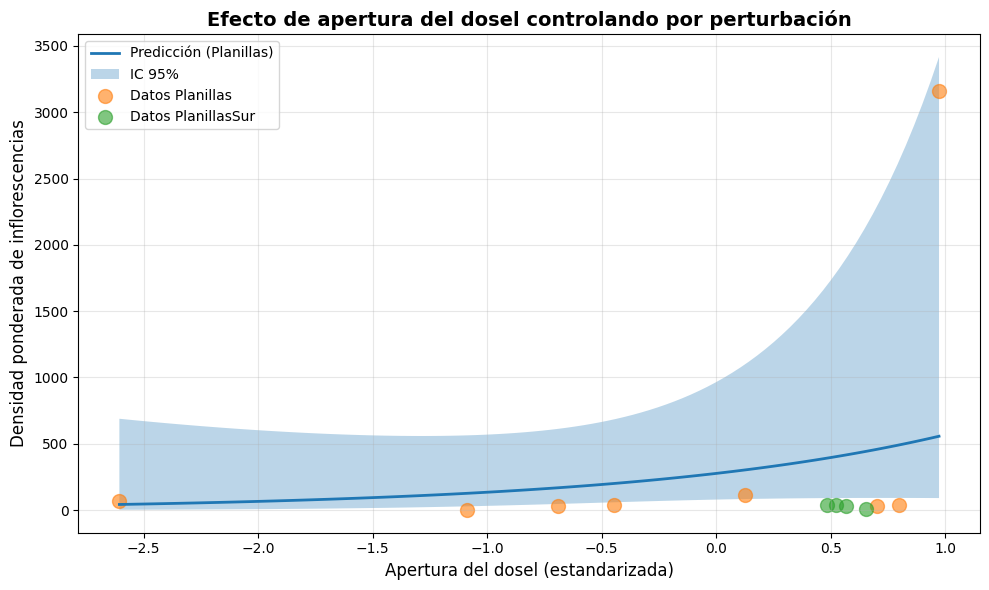

In [6]:
# Nivel base de perturbación
base = df["perturbacion"].cat.categories[0]

new = pd.DataFrame({
    "apertura_s": np.linspace(df.apertura_s.min(), df.apertura_s.max(), 100),
    "perturbacion": base
})

pred = model.get_prediction(new)
pred_summary = pred.summary_frame()

plt.figure(figsize=(10, 6))
plt.plot(new.apertura_s, pred_summary["mean"], 
         label=f"Predicción ({base})", linewidth=2)

plt.fill_between(
    new.apertura_s,
    pred_summary["mean_ci_lower"],
    pred_summary["mean_ci_upper"],
    alpha=0.3,
    label="IC 95%"
)

# Añadir puntos observados diferenciados por perturbación
for pert in df["perturbacion"].cat.categories:
    subset = df[df["perturbacion"] == pert]
    plt.scatter(subset.apertura_s, subset.densidad_ponderada, 
                alpha=0.6, s=100, label=f"Datos {pert}")

plt.xlabel("Apertura del dosel (estandarizada)", fontsize=12)
plt.ylabel("Densidad ponderada de inflorescencias", fontsize=12)
plt.title("Efecto de apertura del dosel controlando por perturbación", 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Validación del modelo (estilo DHARMa)


### 7.1 Obtener residuos y valores ajustados


In [12]:
resid_dev = model.resid_deviance.copy()
fitted = model.fittedvalues.copy()

print("Estadísticas de residuos:")
print(f"Media: {resid_dev.mean():.4f}")
print(f"Desviación estándar: {resid_dev.std():.4f}")

Estadísticas de residuos:
Media: -0.6813
Desviación estándar: 1.4818


### 7.2 QQ-Plot de residuos


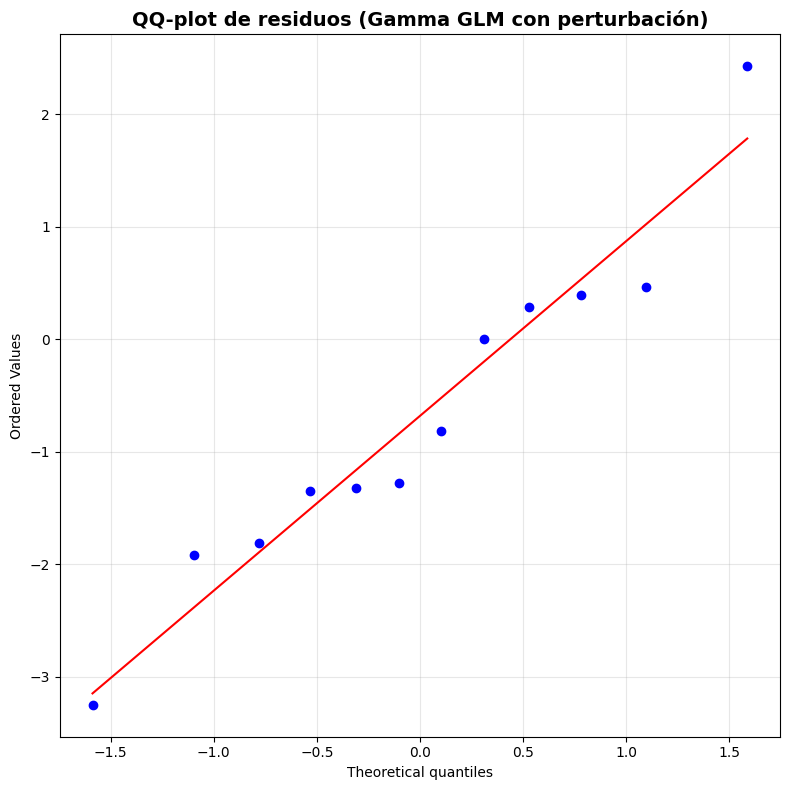

In [11]:
plt.figure(figsize=(8, 8))
st.probplot(resid_dev, dist="norm", plot=plt)
plt.title("QQ-plot de residuos (Gamma GLM con perturbación)", 
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7.3 Residuos vs valores ajustados


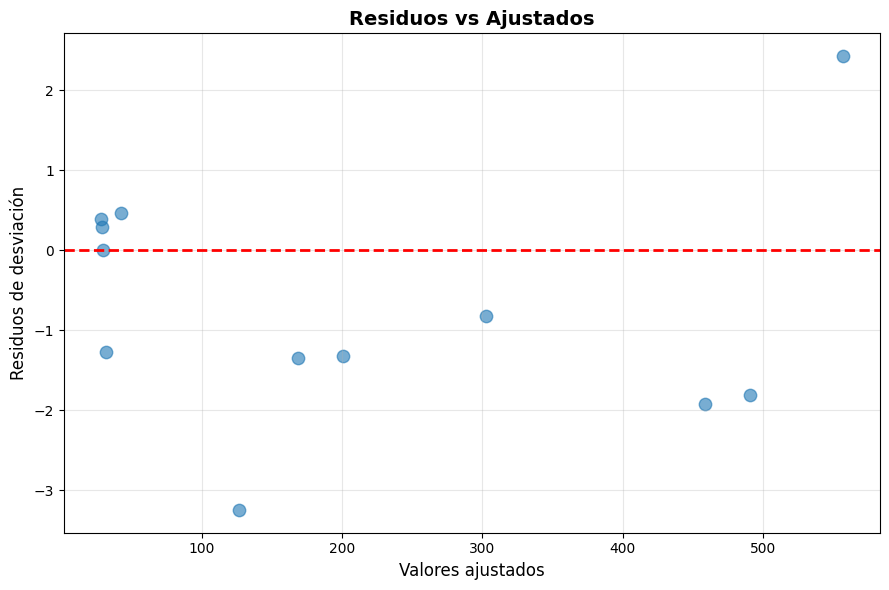

In [10]:
plt.figure(figsize=(9, 6))
plt.scatter(fitted, resid_dev, s=80, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Valores ajustados", fontsize=12)
plt.ylabel("Residuos de desviación", fontsize=12)
plt.title("Residuos vs Ajustados", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7.4 Test de heterocedasticidad (Breusch-Pagan)


In [9]:
# Calcular residuos y valores ajustados si no existen
if 'resid_dev' not in locals() or 'fitted' not in locals():
    resid_dev = model.resid_deviance.copy()
    fitted = model.fittedvalues.copy()

bp = het_breuschpagan(resid_dev, sm.add_constant(fitted))

print("="*80)
print("TEST DE BREUSCH-PAGAN (Heterocedasticidad)")
print("="*80)
print(f"Estadístico LM: {bp[0]:.4f}")
print(f"p-value: {bp[1]:.4f}")

if bp[1] > 0.05:
    print("\n✔ No se detecta heterocedasticidad fuerte (p > 0.05)")
else:
    print("\n⚠ Posible heterocedasticidad detectada (p < 0.05). Revisar modelo.")

TEST DE BREUSCH-PAGAN (Heterocedasticidad)
Estadístico LM: 1.9385
p-value: 0.1638

✔ No se detecta heterocedasticidad fuerte (p > 0.05)


### 7.5 Identificación de puntos influyentes (Cook's Distance)


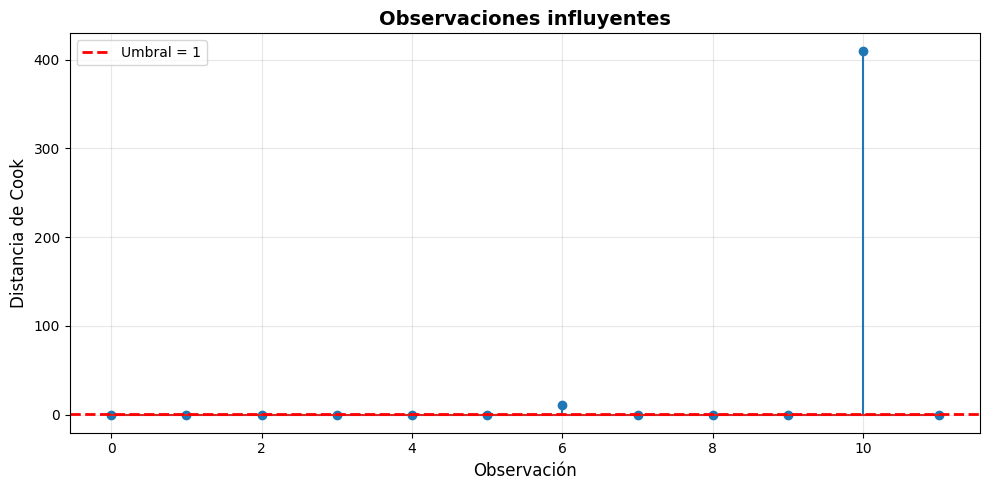


Observaciones con Cook's distance > 1: [np.int64(6), np.int64(10)]


In [7]:
influence = model.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(10, 5))
plt.stem(cooks)
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Umbral = 1')
plt.xlabel("Observación", fontsize=12)
plt.ylabel("Distancia de Cook", fontsize=12)
plt.title("Observaciones influyentes", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

high_influence = np.where(cooks > 1)[0]
print(f"\nObservaciones con Cook's distance > 1: {list(high_influence)}")
if len(high_influence) == 0:
    print("✔ No hay observaciones extremadamente influyentes")

## 8. Resumen e interpretación final del modelo


In [8]:
print("="*80)
print("INTERPRETACIÓN FINAL DEL MODELO CON PERTURBACIÓN")
print("="*80)

# Efecto de apertura
p_ap = model.pvalues["apertura_s"]
if p_ap < 0.05:
    print("✔ APERTURA del dosel es SIGNIFICATIVA")
    print(f"  (p = {p_ap:.4f} < 0.05)")
else:
    print("⚠ APERTURA del dosel NO es significativa")
    print(f"  (p = {p_ap:.4f} > 0.05)")

print(f"  β = {beta_ap:.4f}, exp(β) = {exp_beta_ap:.4f}")

# Efecto de perturbación
if len(pert_params) > 0:
    p_pert = model.pvalues[pert_name]
    if p_pert < 0.05:
        print(f"\n✔ PERTURBACIÓN es SIGNIFICATIVA")
        print(f"  (p = {p_pert:.4f} < 0.05)")
    else:
        print(f"\n⚠ PERTURBACIÓN NO es significativa")
        print(f"  (p = {p_pert:.4f} > 0.05)")
    
    print(f"  β = {beta_pert:.4f}, exp(β) = {exp_beta_pert:.4f}")

print("\n" + "="*80)
print("INTERPRETACIÓN ECOLÓGICA")
print("="*80)
print("""
Este modelo Gamma GLM permite:
1. Capturar la asimetría típica de densidades ecológicas
2. Evaluar el efecto de apertura del dosel (variable continua)
3. Incorporar diferencias estructurales entre sitios (perturbación categórica)
4. Distinguir si la perturbación modifica la densidad esperada después de 
   controlar por apertura del dosel

El coeficiente exp(β) describe cambios proporcionales, más realistas que 
diferencias lineales en contextos ecológicos.
""")

print("="*80)
print("NOTA: Ejecutar las celdas de validación (7.1-7.5) para revisar:")
print("="*80)
print("  • QQ-plot para normalidad de residuos")
print("  • Residuos vs Ajustados para homogeneidad")
print("  • Test de Breusch-Pagan para heterocedasticidad")
print("  • Distancia de Cook para puntos extremos")
print("="*80)

INTERPRETACIÓN FINAL DEL MODELO CON PERTURBACIÓN
⚠ APERTURA del dosel NO es significativa
  (p = 0.1910 > 0.05)
  β = 0.7188, exp(β) = 2.0520

✔ PERTURBACIÓN es SIGNIFICATIVA
  (p = 0.0238 < 0.05)
  β = -2.6356, exp(β) = 0.0717

INTERPRETACIÓN ECOLÓGICA

Este modelo Gamma GLM permite:
1. Capturar la asimetría típica de densidades ecológicas
2. Evaluar el efecto de apertura del dosel (variable continua)
3. Incorporar diferencias estructurales entre sitios (perturbación categórica)
4. Distinguir si la perturbación modifica la densidad esperada después de 
   controlar por apertura del dosel

El coeficiente exp(β) describe cambios proporcionales, más realistas que 
diferencias lineales en contextos ecológicos.

NOTA: Ejecutar las celdas de validación (7.1-7.5) para revisar:
  • QQ-plot para normalidad de residuos
  • Residuos vs Ajustados para homogeneidad
  • Test de Breusch-Pagan para heterocedasticidad
  • Distancia de Cook para puntos extremos
